<a href="https://colab.research.google.com/github/xmpuspus/census-income-webapp/blob/master/TabularClassificationFastAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
import gc
gc.collect()

13946

In [0]:
# Load FastAI
from fastai import *
from fastai.tabular import *

In [0]:
# train test split
from sklearn.model_selection import train_test_split

In [24]:
# Load data from google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_repo_url = '/content/gdrive/My Drive/Datasets/'
data_url = data_repo_url + 'Census Income/census.csv'

In [0]:
# Load Data
df = pd.read_csv(data_url)


# Rename target
df['high_income'] = df['income'] == '>50K'


In [27]:
df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,high_income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,False
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,False
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,False
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,False
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,False


In [28]:
df.high_income.value_counts()/df.shape[0]

False    0.752156
True     0.247844
Name: high_income, dtype: float64

In [0]:
dep_var = 'high_income'
cat_names = ['workclass', 'education_level', 'marital-status',
              'occupation', 'relationship', 'race', 'sex', 
             'native-country']
cont_names = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']

In [11]:
print("Categorical columns are : ", cat_names)
print('Continuous numerical columns are :', cont_names)
procs = [FillMissing, Categorify, Normalize]

Categorical columns are :  ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
Continuous numerical columns are : ['age', 'capital-gain', 'capital-loss', 'hours-per-week']


In [0]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [13]:
df_train.shape, df_test.shape

((31655, 15), (13567, 15))

In [14]:
# Transformations
procs = [FillMissing, Categorify, Normalize]

# Test Tabular List
test = TabularList.from_df(df_test, cat_names=cat_names, cont_names=cont_names, procs=procs)

# Train Data Bunch
data = (TabularList.from_df(df_train, path='.', cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_idx(list(range(0,200)))
                        .label_from_df(cols = dep_var)
                        .add_test(test, label=0)
                        .databunch())

data.show_batch(rows=10)

workclass,education_level,marital-status,occupation,relationship,race,sex,native-country,age,capital-gain,capital-loss,hours-per-week,target
Self-emp-not-inc,7th-8th,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,2.2269,-0.1446,-0.2185,-2.0769,False
Local-gov,Bachelors,Divorced,Prof-specialty,Not-in-family,Black,Female,United-States,0.7901,-0.1446,-0.2185,-0.0787,False
Private,Some-college,Divorced,Other-service,Unmarried,White,Female,United-States,0.7901,-0.1446,-0.2185,0.1711,False
Self-emp-inc,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,-0.1174,0.2668,-0.2185,0.7539,True
Private,Some-college,Never-married,Sales,Not-in-family,White,Female,United-States,-1.2517,-0.1446,-0.2185,-1.9937,False
Self-emp-not-inc,HS-grad,Married-spouse-absent,Other-service,Unmarried,Black,Female,United-States,-0.1174,-0.1446,-0.2185,-0.0787,False
Private,HS-grad,Married-civ-spouse,Sales,Wife,White,Female,Canada,1.2438,-0.1446,-0.2185,-0.0787,True
Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,2.2269,-0.1446,-0.2185,-0.0787,True
Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,0.1851,-0.1446,-0.2185,-0.0787,False
Self-emp-not-inc,Some-college,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,0.8657,-0.1446,-0.2185,1.1702,False


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.376983,0.383337,0.800000,00:08
1,0.356043,0.325112,0.835000,00:09
2,0.339325,0.325878,0.835000,00:08
3,0.331342,0.322340,0.840000,00:08
4,0.318765,0.309819,0.835000,00:08


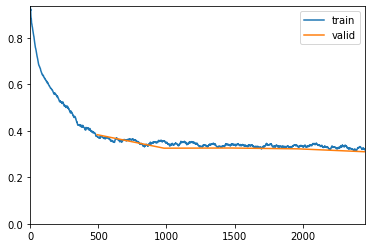

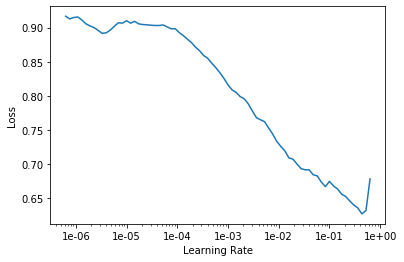

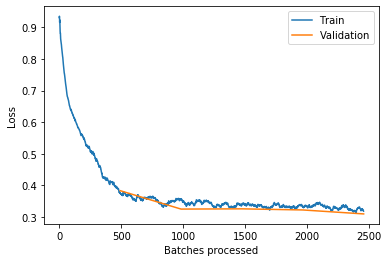

In [15]:
# Create deep learning model
learn = tabular_learner(data, layers=[15, 100, 200], metrics=accuracy, emb_drop=0.1, callback_fns=ShowGraph)

# select the appropriate learning rate
learn.lr_find()

# we typically find the point where the slope is steepest
learn.recorder.plot()

# Fit the model based on selected learning rate
learn.fit_one_cycle(5, max_lr=1e-3)

# Analyse our model
learn.model
learn.recorder.plot_losses()

In [0]:
# Predict our target value
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)

In [17]:
labels

tensor([1, 0, 0,  ..., 0, 0, 0])

In [0]:
# metrics
from sklearn.metrics import classification_report

In [19]:
report = classification_report(df_test['high_income'], labels)
print(report)

              precision    recall  f1-score   support

       False       0.88      0.93      0.90     10193
        True       0.74      0.60      0.66      3374

    accuracy                           0.85     13567
   macro avg       0.81      0.76      0.78     13567
weighted avg       0.84      0.85      0.84     13567

